# Animal Identification
***
## Table of Contents
***

In [114]:
import torch
import os
from torch import nn
from torchvision import transforms
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

## 1. Introduction

## 2. Loading Custom Dataset

In [115]:
data_path = Path("_datasets/animal-10/raw-img")

if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"{data_path} Directory does not exist !")

_datasets/animal-10/raw-img directory exists.


In [126]:
def walk_through_dir(dir_path):
    for (
        directory_path,
        directory_names,
        file_names,
    ) in os.walk(dir_path):
        print(
            f"{len(directory_names)} directories and {len(file_names)} images found in {directory_path}"
        )

walk_through_dir(data_path)

10 directories and 0 images found in _datasets/animal-10/raw-img
0 directories and 3098 images found in _datasets/animal-10/raw-img/gallina
0 directories and 4821 images found in _datasets/animal-10/raw-img/ragno
0 directories and 1668 images found in _datasets/animal-10/raw-img/gatto
0 directories and 2112 images found in _datasets/animal-10/raw-img/farfalla
0 directories and 1866 images found in _datasets/animal-10/raw-img/mucca
0 directories and 2623 images found in _datasets/animal-10/raw-img/cavallo
0 directories and 4863 images found in _datasets/animal-10/raw-img/cane
0 directories and 1820 images found in _datasets/animal-10/raw-img/pecora
0 directories and 1862 images found in _datasets/animal-10/raw-img/scoiattolo
0 directories and 1446 images found in _datasets/animal-10/raw-img/elefante


In [117]:
class CustomDataset(Dataset):
    def __init__(self, img_path, transform=None) -> None:
        self.img_path = img_path
        self.transform = transform
        self.all_paths = [path for path in img_path.glob("*/*") if path.is_file()]

    def __len__(self):
        return len(self.all_paths)

    def __getitem__(self, index):
        single_file_path = self.all_paths[index]
        img = Image.open(single_file_path).convert("RGB")
        label = single_file_path.parent.name

        if self.transform:
            img = self.transform(img)
        return img, label


In [118]:
custom_ds = CustomDataset(data_path)

In [ ]:
def display_raw_samples(dataset: Dataset) -> None:
    figure = plt.figure(figsize=(9, 9))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(0, len(dataset), (1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img)
    plt.show()

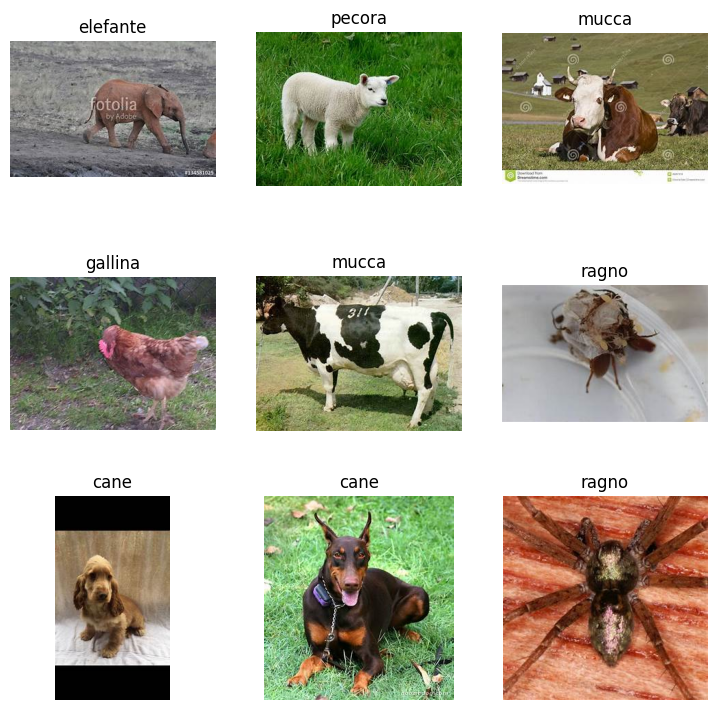

In [125]:
torch.manual_seed(2)
display_raw_samples(custom_ds)